# __Анализ конверсий пазлов (картинок)__  
## Период с 01.03.22 по 12.05.22

In [1]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# __Можно пропустить и перейти к ячейке [21].__  
## __Подготовительная часть - обработка, отсеивание и привидение в читаемы вид данных.__  

__Загружаем данные из файла выгрузки Яндекса__

In [2]:
data=pd.read_csv('events (3).csv')
pd.set_option('display.max_rows', 10) # None
pd.set_option('display.max_columns', 50) # None
data.head()

,app_version_name,event_name,event_json,event_datetime
0,1.4.3,cdn_config_categories_download_start,"{""balance"":""340"",""days_in_game"":""1"",""PuzzleCom...",2022-05-08 17:14:24
1,1.4.3,game_puzzle_onscreen,"{""puzzle_id"":""38"",""Order_number"":""11"",""puzzle_...",2022-05-08 17:14:24
2,1.4.1,game_puzzle_pause,"{""puzzle_id"":""13"",""Order_number"":""13"",""categor...",2022-05-08 18:56:32
3,1.4.3,game_puzzle_pause,"{""puzzle_id"":""38"",""Order_number"":""11"",""categor...",2022-05-08 17:14:24
4,1.4.1,game_puzzle_placed,"{""puzzle_id"":""13"",""Order_number"":""13"",""PuzzleS...",2022-05-08 18:55:14


In [3]:
data.event_datetime.max()

'2022-05-12 20:46:41'

In [4]:
# в процессе исследования был полезен датасет "в сборе"
# data_full = pd.concat([data[['event_name', 'event_datetime']],data_json], axis=1)

__Все значения чтолбца event_name (77 значений)__

In [5]:
data['event_name'].value_counts()[0:77]

video_ads_available       12710480
show_image                 3814951
ui_element                 1712964
ui_screen                  1468591
show_interface             1314588
                            ...   
image_screen_buy_video        1262
complete_achievement           593
iap_purchase                   455
iap_purchase_invalid           350
iap_purchase_valid              26
Name: event_name, Length: 77, dtype: int64

__Любопытно, что лежит в event_name == 'data_info'__ (пока ничего интересного)

In [6]:
data_info=data[data['event_name']=='data_info']
data_info_json = pd.json_normalize(list(map(json.loads, data_info.event_json)))
data_info_json.head(10)

,Memory,CoreCount,CoreFrequency,ResolutionH,ResolutionW,Resolution,ScreenW,ScreenH,ScreenD,Screen,UTC,Version,MCC,balance,days_in_game,PuzzleComplete,PuzzleStart
0,7611,8,2200,2400,1080,1080x2400,2_25,5,5_482928,2_25x5,1,1_4_3,60303,0,0,0,0
1,1370,8,1500,1280,720,720x1280,2_25,4,4_58939,2_25x4,3,1_4_3,63601,0,0,0,0
2,2933,3,1300,1280,720,720x1280,2_25,4,4_58939,2_25x4,1,1_4_3,60301,0,0,0,0
3,3347,8,2361,2220,1080,1080x2220,2_25,4_625,5_14326,2_25x4_625,-5,1_4_1,311480,500,0,0,0
4,902,4,1248,960,540,540x960,2_25,4,4_58939,2_25x4,5,1_4_1,41001,500,0,0,0
5,3683,8,2002,1600,720,720x1600,"2,571429","5,714286","6,266203","2,571429x5,714286",1,1_4_3,60501,0,0,0,0
6,1945,8,1586,1440,900,900x1440,5,8,9_433981,5x8,-4,1_4_3,,0,0,0,0
7,1782,8,2301,1520,720,720x1520,"2,25","4,75","5,255949","2,25x4,75",9,1_4_1,51010,500,0,0,0
8,2778,8,2301,1520,720,720x1520,"2,25","4,75","5,255949","2,25x4,75",7,1_4_3,45204,0,0,0,0
9,2865,8,2362,1920,1200,1200x1920,"3,75",6,"7,075486","3,75x6",-5,1_4_3,,0,0,0,0


__Оставляем только интересующие нас события/event_name, связанные с пазлами, а именно:__  
show_image  
game_puzzle_start  
game_puzzle_complete  
game_puzzle_quit  
game_puzzle_concat  
game_puzzle_receive  
game_puzzle_click  
game_puzzle_start_continue  
и далее по списку ниже
  
 


In [7]:
data=data[data['event_name'].isin(['show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit', 'game_puzzle_concat', 'game_puzzle_receive', 'game_puzzle_click', 'game_puzzle_start_continue', 'game_puzze_onscreen'])].reset_index(drop=True)
data.head()

,app_version_name,event_name,event_json,event_datetime
0,1.4.1,game_puzzle_click,"{""category_id"":""4"",""puzzle_id"":""13"",""Order_num...",2022-05-09 00:31:12
1,1.4.1,game_puzzle_click,"{""category_id"":""32"",""puzzle_id"":""1"",""Order_num...",2022-05-09 00:41:00
2,1.4.3,game_puzzle_click,"{""category_id"":""34"",""puzzle_id"":""38"",""Order_nu...",2022-05-09 01:43:02
3,1.4.3,game_puzzle_click,"{""category_id"":""21"",""puzzle_id"":""60"",""Order_nu...",2022-05-09 02:27:31
4,1.4.3,game_puzzle_click,"{""category_id"":""4"",""puzzle_id"":""31"",""Order_num...",2022-05-09 02:35:17


__Вынимаем из data.event_json информацию в читаемый/преобразуемый вид__   

In [8]:
data_json = pd.json_normalize(list(map(json.loads, data.event_json)))
data_json.head(30)

,category_id,puzzle_id,Order_number,is_purchased,place,balance,days_in_game,PuzzleComplete,PuzzleStart,puzzle_uid,Rotate,Difficulty,completed,background,Progress,Continue,started,available,Percent,Concat,Placed
0,4,13,13,True,daily,1010,3,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32,1,1,False,inprogress,1015,3,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34,38,11,True,daily,340,1,41,42,1_38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,60,63,True,inprogress,260,2,45,47,1_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,31,31,False,inprogress,265,2,46,48,21_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,4,13,13,NaN,inprogress,1010,3,3,10,NaN,0,36,0,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN
26,34,38,11,NaN,inprogress,340,1,41,43,34_38,0,36,0,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN
27,34,38,11,NaN,inprogress,340,1,41,43,34_38,0,36,0,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN
28,34,38,11,NaN,inprogress,340,1,41,43,34_38,0,36,0,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# значения столбца 'place'
data_json.place.value_counts()

daily            2807817
category         1613520
in_progress       277618
inprogress        186591
free_category     115250
completed          88849
none               18948
Name: place, dtype: int64

In [10]:
data_full = pd.concat([data[['event_name', 'event_datetime', 'app_version_name']], data_json], axis=1)

In [11]:
#data_full.to_csv('data_full_01.03_05.05.csv')

__Формируем dataframe c событиями и пазлами. Добавляем столбец puzz_cat_id, который будет однозначно идентифицировать puzzle_id. В нем: IDпазла_IDкатегории.__

In [12]:
data_work = data[['event_name', 'event_datetime', 'app_version_name']]
data_work['cat_puzzle_id'] = data_json.category_id.astype(str) + '_' + data_json.puzzle_id.astype(str)
data_work = pd.concat([data_work, data_json[['place', 'balance', 'days_in_game', 'PuzzleComplete', 'PuzzleStart']]], axis=1)

In [13]:
# Преобразуем типы данных
data_work['days_in_game'] =pd.to_numeric(data_work.days_in_game)
data_work['PuzzleComplete'] =pd.to_numeric(data_work.PuzzleComplete)
data_work['PuzzleStart'] =pd.to_numeric(data_work.PuzzleStart)

In [14]:
data_work.dtypes

event_name           object
event_datetime       object
app_version_name     object
cat_puzzle_id        object
place                object
balance              object
days_in_game          int64
PuzzleComplete      float64
PuzzleStart         float64
dtype: object

In [15]:
data_work.event_datetime.min()

'2022-03-01 00:00:11'

### __Будем говорить только о конверсии start to complete__

In [16]:
# конверсии по версиям приложения
conversion_full_by_version = pd.DataFrame()
sfbv_complete = data_work[data_work['event_name'].isin(['game_puzzle_complete'])].groupby(by=['cat_puzzle_id','app_version_name']).count()['event_datetime']
sfbv_start = data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].groupby(by=['cat_puzzle_id', 'app_version_name']).count()['event_datetime']
conversion_full_by_version['conv_full'] = round(sfbv_complete*100 / sfbv_start, 2)
conversion_full_by_version['full_starts'] = sfbv_start
conversion_full_by_version.reset_index(drop=False, inplace=True)

In [17]:
# полная конверсия старта в комплит по всем событиям g_p_start = g_p_start + g_p_start_continue без фильтров
conversion = pd.DataFrame()
conversion['conv_full'] = round(data_work[data_work['event_name'].isin(['game_puzzle_complete'])].groupby(by='cat_puzzle_id').count()['event_datetime']*100\
     / data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].groupby(by='cat_puzzle_id').count()['event_datetime'],2)

conversion['full_starts'] = data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].groupby(by='cat_puzzle_id').count()['event_datetime']

In [18]:
# конверсия вовращения к пазлу после перерыва
conversion['conv_of_return'] = round(data_work[data_work['event_name'].isin(['game_puzzle_start_continue'])].groupby(by='cat_puzzle_id').count()['event_datetime']*100\
     / data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].groupby(by='cat_puzzle_id').count()['event_datetime'],2)

conversion['returns'] = data_work[data_work['event_name'].isin(['game_puzzle_start_continue'])].groupby(by='cat_puzzle_id').count()['event_datetime']

In [19]:
# конверсия пазлов при первом старте
# PuzzleComplete == 1 потому что зачисление собранного пазла происходит "мгновенно"
# PuzzleStart == 0 потому что зачисление старта пазла происходит с задержкой на 1 ед.
conversion['conv_first_start'] =  round(data_work[data_work['event_name'] == 'game_puzzle_complete'].query('PuzzleComplete == 1').groupby(by='cat_puzzle_id').count()['event_datetime']*100\
    / data_work[data_work['event_name'] == 'game_puzzle_start'].query('PuzzleStart == 0').groupby(by='cat_puzzle_id').count()['event_datetime'],2)
conversion['first_starts'] = data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].query('PuzzleStart == 0').groupby(by='cat_puzzle_id').count()['event_datetime']

In [20]:
# конверсия пазлов при старте 1+
pd.set_option('display.max_rows', 50) # None
pd.set_option('display.max_columns', None) # None
conversion['conv_one_plus_start'] =  round(data_work[data_work['event_name'] == 'game_puzzle_complete'].query('PuzzleStart >= 1').groupby(by='cat_puzzle_id').count()['event_datetime']*100\
    / data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].query('PuzzleStart > 0').groupby(by='cat_puzzle_id').count()['event_datetime'],2)
conversion['one_plus_starts'] = data_work[data_work['event_name'].isin(['game_puzzle_start', 'game_puzzle_start_continue'])].query('PuzzleStart >= 1').groupby(by='cat_puzzle_id').count()['event_datetime']


### __Конверсии старта в комплит по пазлам__  
__conv_full__ - полная конверсия = все комплиты / все старты  
__full_starts__ - количество стартов  
__conv_of_return__ - конверсия возвращений к пазлу = все старты / все возвращения  
__returns__ - количество возвращений к пазлу  
__conv_first_start__ - конверсия первого (для пользователя) стартапо пазлу = старт(с PuzzleStart==0) / комплит  
__first_starts__ - количество первых стартов  
__conv_one_plus_start__ - конверсия всех последующих (за первым) стартов  
__one_plus_starts__ - количество стартов после первого

In [21]:
#pd.set_option('display.max_rows', 50) # None
#d.set_option('display.max_columns', 50) 
conversion.sort_values('full_starts', ascending=False).head(15) # сортировка по самым частым в старте !!!!!!!!!!!!!!!!!!!

,conv_full,full_starts,conv_of_return,returns,conv_first_start,first_starts,conv_one_plus_start,one_plus_starts
cat_puzzle_id,,,,,,,,
21_3,54.25,6363,24.45,1556,57.84,1627.0,72.89,4736
1_33,60.27,6346,23.45,1488,60.44,819.0,69.21,5527
31_8,58.92,5604,23.18,1299,60.93,1226.0,75.42,4378
34_1,55.03,5561,26.22,1458,56.05,1140.0,69.22,4421
1_64,52.96,2732,26.79,732,63.58,1145.0,91.18,1587
21_32,53.96,1364,27.93,381,56.39,227.0,64.73,1137
1_99,50.30,1163,27.94,325,47.88,259.0,64.71,904
1_38,62.78,1115,24.30,271,62.86,140.0,71.79,975
7_40,57.43,895,28.04,251,61.90,84.0,63.38,811


### __ТОП-5 самых часто стартуемых пазлов с разбивкой по версиям приложения.__

In [22]:
conversion_full_by_version[conversion_full_by_version['cat_puzzle_id'].isin(['21_3', '1_33', '31_8', '34_1', '1_64'])].groupby(by=['cat_puzzle_id','app_version_name', 'conv_full']).sum().head(50)

full_starts
cat_puzzle_id app_version_name conv_full             
1_33          1.3.28           68.97             29.0
              1.3.29           52.38             63.0
              1.3.30           61.49           1872.0
              1.3.31           52.10            119.0
              1.3.32           53.33             15.0
              1.3.33           64.71             17.0
              1.4              61.32           1877.0
              1.4.1            59.22           1670.0
              1.4.3            58.57            683.0
1_64          1.3.26           50.00              2.0
              1.3.28           100.00             6.0
              1.3.29           70.00             10.0
              1.3.30           67.07            167.0
              1.3.31           58.54             41.0
              1.3.32           80.00              5.0
              1.3.33           50.00              4.0
              1.4              73.23            127.0
              1.4.1            65.05            186.0
              1.4.2            50.00              2.0
              1.4.3            49.43           2177.0
21_3          1.3.28           104.55            22.0
              1.3.29           59.18             49.0
              1.3.30           54.60           2020.0
              1.3.31           46.67            165.0
              1.3.32           69.23             13.0
              1.3.33           53.85             26.0
              1.4              54.87           2136.0
              1.4.1            52.97           1922.0
              1.4.3            77.78              9.0
31_8          1.3.26           100.00             1.0
              1.3.28           133.33            18.0
              1.3.29           77.14             35.0
              1.3.30           61.09           1794.0
              1.3.31           46.81            141.0
              1.3.32           41.67             24.0
              1.3.33           45.16             31.0
              1.4              58.44           1855.0
              1.4.1            57.46           1688.0
              1.4.3            62.50             16.0
34_1          1.3.26           100.00             1.0
              1.3.28           57.14             28.0
              1.3.29           81.82             22.0
              1.3.30           54.73           1933.0
              1.3.31           45.00            160.0
              1.3.32           46.15             13.0
              1.3.33           55.56             18.0
              1.4              56.53           1700.0
              1.4.1            54.35           1665.0
              1.4.3            61.90             21.0

Воспользуемся тестом Шапиро-Уилка для оценки нормальности распределения значений конверсии start to complete.  
H0 - распределение нормальное  
H1 - распределение другое  
Statistics=0.999, p-value=0.72629  
Принимаем нулевую гипотезу. Распределение является нормальным.  

In [23]:
# Полная конверсия распределена нормально.
import scipy
stat, p = scipy.stats.shapiro(list(conversion['conv_full'])) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

Statistics=0.999, p-value=0.72629


c:\Users\sorok\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


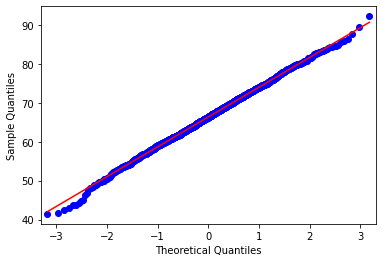

In [24]:
from statsmodels.graphics.gofplots import qqplot
qqplot(conversion['conv_full'], line='s')
plt.show()

Text(0.5, 1.0, 'Конверсия конверсия без первых запусков')

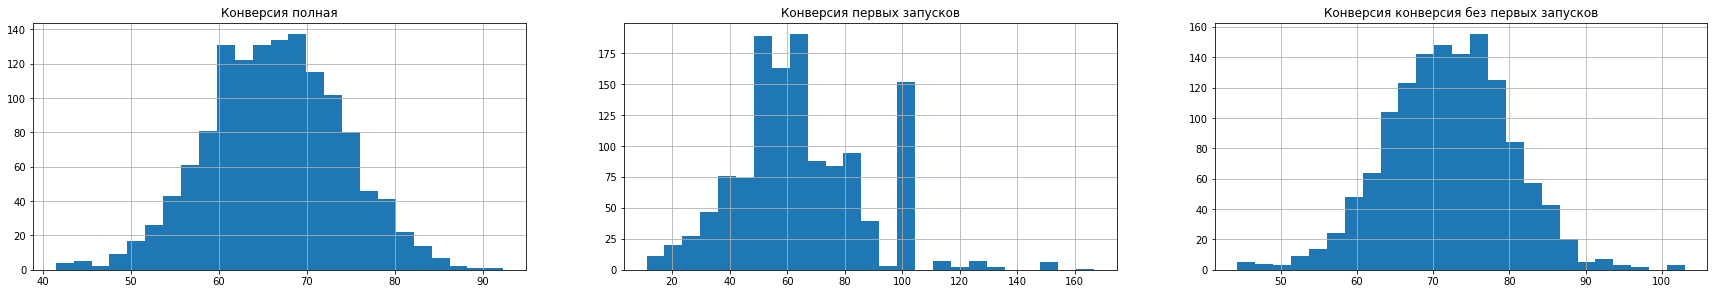

In [25]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
conversion.conv_full.hist(bins=25)
plt.title("Конверсия полная")

plt.subplot(2, 3, 2)
conversion.conv_first_start.hist(bins=25)
plt.title("Конверсия первых запусков")

plt.subplot(2, 3, 3)
conversion.conv_one_plus_start	.hist(bins=25)
plt.title("Конверсия конверсия без первых запусков")

#### __Расчитаем среднее, медиану, диспресию и доверительный интервал для конверсии start to complete__

In [26]:
mean, sigma = np.mean(list(conversion.conv_full)), np.std(list(conversion.conv_full))
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)

print('Среднее для конверсии start to complete ', round(conversion.conv_full.mean(),2))
print('Медиана для конверсии start to complete ', round(conversion.conv_full.median(),2))
print('Дисперсия для конверсии start to complete ', round(np.var(conversion.conv_full),2))
print('Стандартное отклонение для конверсии start to complete ', round(np.std(conversion.conv_full),2))
print('95% доверительный интервал для конверсии --/-- ', list(np.round(conf_int,2)))

Среднее для конверсии start to complete  66.39
Медиана для конверсии start to complete  66.34
Дисперсия для конверсии start to complete  58.87
Стандартное отклонение для конверсии start to complete  7.67
95% доверительный интервал для конверсии --/--  [51.35, 81.42]


Text(0.5, 1.0, '95% Confidence interval of conv_start_to_complete')

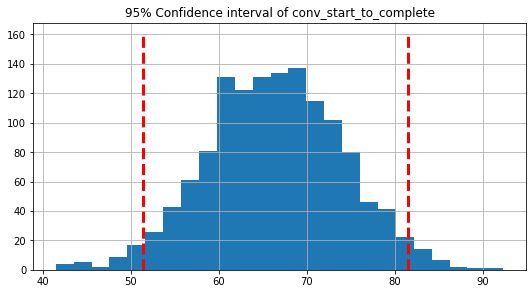

In [27]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
conversion.conv_full.hist(bins=25)
plt.vlines(conf_int[0],0,160, colors='red', linewidth = 3, linestyles='--')
plt.vlines(conf_int[1],0,160, colors='red', linewidth = 3, linestyles='--')
plt.title("95% Confidence interval of conv_start_to_complete")


#### __Гипотеза/идея 1__  
1. Найдем 95% доверительный интервал для среднего значения конверсии start to complete.  
2. Выделим подвыборку пазлов, конверсии которых, попадают в п.1.  
3. Найдем среднее значение complete для подвыборки из п.2.  
4. Станем утверждать, что пазлы набравшие complete >= среднему из п.3 при этом имеющие низкую конверсию (не попадающие в доверительный интервал конверсии), не интересны пользователю.

Найдем 95% доверительный интервал для среднего значения конверсии start to complete

In [28]:
mean, sigma = np.mean(list(conversion.conv_full)), np.std(list(conversion.conv_full))
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma/np.sqrt(len(list(conversion.conv_full))))

print('Среднее значение для конверсии start to complete ', round(mean,2))
print('95% доверительный интервал для среднего значения конверсии start to complete ', list(np.round(conf_int,2)))

Среднее значение для конверсии start to complete  66.39
95% доверительный интервал для среднего значения конверсии start to complete  [65.97, 66.8]


Посмотрим какое количество completе'ов приходится на найденные средние значения (из найденного доверительного интервала) конверсии start to complete
# ДАЛЕЕ НЕ ДОДЕЛАНО !!! уже не соображал 12.05.22

array([[<AxesSubplot:title={'center':'conv_full'}>,
        <AxesSubplot:title={'center':'full_starts'}>,
        <AxesSubplot:title={'center':'conv_of_return'}>],
       [<AxesSubplot:title={'center':'returns'}>,
        <AxesSubplot:title={'center':'conv_first_start'}>,
        <AxesSubplot:title={'center':'first_starts'}>],
       [<AxesSubplot:title={'center':'conv_one_plus_start'}>,
        <AxesSubplot:title={'center':'one_plus_starts'}>, <AxesSubplot:>]],
      dtype=object)

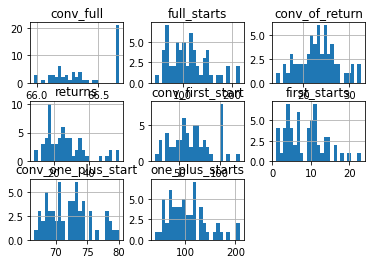

In [29]:
# гистограмма распределения complete'ов среди средних конверсий start to complete
complets_for_conf_int = conversion.query('conv_full>@conf_int[0] and conv_full<@conf_int[1]')
complets_for_conf_int.hist(bins=25)

Найдем среднее complete для среднего по конверсии start to complete, восопльзуемся bootstrap

In [30]:
# воспользуемся bootstrap
boot_it = 1000 # количсетво бустрап подвыборок
boot_len = 100 # объем сэмплирования
boot_data = []
for i in range(boot_it): # извлекаем подвыборки
    samples = list(complets_for_conf_int.sample(boot_len, replace = True).values)
    boot_data.append(round(np.mean(samples),2))

# гистограмма средних из бутстрапа
#pd_boot_data = pd.DataFrame(boot_data)
#pd_boot_data.hist(bins=25)

In [31]:
print('Среднее значение complete для средних конверсий start to complete', round(np.mean(boot_data)))

ValueError: cannot convert float NaN to integer

#### __Т.е. мы говорим о том что, если наш пазл набрал 68 complete и при этом его конверсия не попадает в доверительный интервал конверсии по всем пазлам, такой пазл не интересен пользователю.__

#### __Результаты.__
1. Расчитан 95% доверительный интервал для значений конверсии start to complete.  
2. Определены выбросы (левые/малые значения - выбросы, с правыми нужно/можно разбираться).
3. Предложена методика поиска неинтересных пазлов (можно играть/менять цифры интервалов и значений)